In [1]:
import time
from pathlib import Path
from six import iteritems
import warnings
import copy
from tqdm import tqdm

from matplotlib import rcParams
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from nilmtk.dataset_converters import convert_redd
from nilmtk import DataSet, TimeFrame, MeterGroup, HDFDataStore
from nilmtk.disaggregate import fhmm_exact, CombinatorialOptimisation, FHMM
from nilmtk.utils import print_dict 

from sklearn.metrics import mean_squared_error

warnings.filterwarnings('ignore')
%matplotlib inline
rcParams['figure.figsize'] = (13, 6)

### Dataset import

Define the paths to the raw REDD low freq and target HDF format files.

In [2]:
redd_low_freq_h5_path = 'data/REDD/low_freq.h5'
redd_low_freq_path = 'data/REDD/low_freq'

# Check if the converted file exists, otherwise convert
if Path(redd_low_freq_h5_path).exists() is not True:
    convert_redd(redd_low_freq_path, redd_low_freq_h5_path)

# Load the data from HDF5 file into memory
redd_low_freq = DataSet(redd_low_freq_h5_path)

# Display the metadata
# print_dict(redd_low_freq.metadata)

# Display buildings
# print_dict(redd_low_freq.buildings)

### Dataset summary

We explore the loaded dataset, specifically showing certain features of the dataset.

1. Dataset metadata
2. Appliances in a sample building
3. Types of the attributes
4. Details of the data

In [3]:
# Dataset metadata
metadata = redd_low_freq.metadata
print('Name: {}'.format(metadata['long_name']))
print('Description: {}'.format(metadata['description']))

meter_devices = metadata['meter_devices']
print('Whole-house measurements: {}'.format(meter_devices['REDD_whole_house']['measurements']))
print('Whole-house sample period: {} seconds'.format(meter_devices['REDD_whole_house']['sample_period']))

print('Appliance-level measurements: {}'.format(meter_devices['eMonitor']['measurements']))
print('Appliance-level sample period: {} seconds'.format(meter_devices['eMonitor']['sample_period']))

# print_dict(redd_low_freq.metadata)

Name: The Reference Energy Disaggregation Data set
Description: Several weeks of power data for 6 different homes.
Whole-house measurements: [{'physical_quantity': 'power', 'type': 'apparent', 'upper_limit': 50000, 'lower_limit': 0}]
Whole-house sample period: 1 seconds
Appliance-level measurements: [{'physical_quantity': 'power', 'type': 'active', 'upper_limit': 5000, 'lower_limit': 0}]
Appliance-level sample period: 3 seconds


In [220]:
# Sample building appliances
building_num = 2
print('Building {} appliances:'.format(building_num))
building = redd_low_freq.buildings[building_num]
for appliance in building.elec.appliances:
    print(appliance.label(pretty=True))

Building 2 appliances:
Dish washer
Microwave
Waste disposal unit
Electric stove
Sockets
Sockets 2
Washer dryer
Fridge
Light


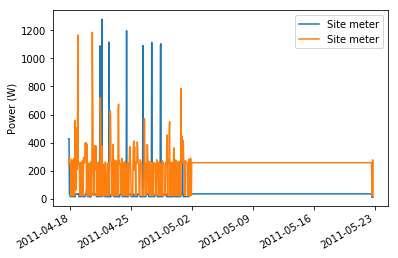

In [221]:
# The power data for both mains (or site) meters the building
mains = building.elec.mains()
mains.plot()

In [222]:
# Both meters power data summed together 
mains_power = mains.power_series_all_data()

Loading data for meter ElecMeterID(instance=2, building=2, dataset='REDD')     
Done loading data all meters for this chunk.


In [223]:
mains_power.head()

2011-04-17 19:18:27-04:00    306.809998
2011-04-17 19:18:28-04:00    306.319977
2011-04-17 19:18:29-04:00    306.400024
2011-04-17 19:18:30-04:00    305.760010
2011-04-17 19:18:31-04:00    321.360016
Name: (power, apparent), dtype: float32

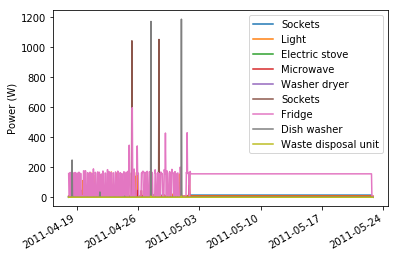

In [224]:
submeters = building.elec.submeters()

submeters.plot()

In [225]:
# All submeters power data summed together 
submeters_power = submeters.power_series_all_data()

Loading data for meter ElecMeterID(instance=11, building=2, dataset='REDD')     
Done loading data all meters for this chunk.


In [226]:
submeters_power.head()

2011-04-18 01:31:39-04:00     NaN
2011-04-18 01:31:42-04:00    29.0
2011-04-18 01:31:45-04:00    29.0
2011-04-18 01:31:48-04:00    29.0
2011-04-18 01:31:51-04:00    27.0
Name: (power, active), dtype: float32

In [227]:
submeters_power[-1:]

2011-05-22 19:59:06-04:00   NaN
Name: (power, active), dtype: float32

### Training and testing data sets split

We use building 1, dividing data into train and test set. The measurement start date is 2011-04-18 and end date, 2011-05-24, so we split data at May 6: 3:1 ratio.

In [13]:
split_date = '28-4-2011' #'14-5-2011'
train_set = DataSet(redd_low_freq_h5_path)
test_set = DataSet(redd_low_freq_h5_path)

train_set.set_window(end=split_date)
test_set.set_window(start=split_date)

In [14]:
train_elec = train_set.buildings[building_num].elec
test_elec = test_set.buildings[building_num].elec

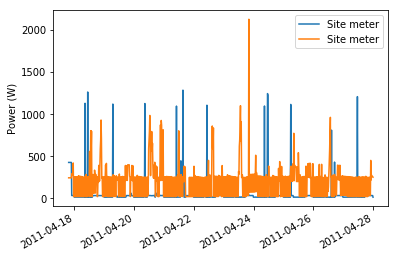

In [15]:
train_elec.mains().plot()

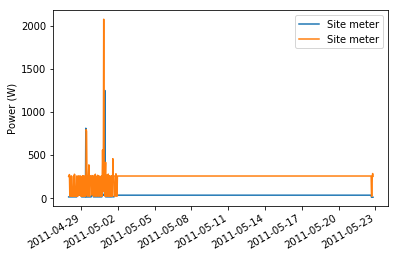

In [16]:
test_elec.mains().plot()

We select the top-5 appliances in terms of energy consumption and use them for our training models.

In [17]:
top_5_train_elec = train_elec.submeters().select_top_k(k=5)

9/9 ElecMeter(instance=11, building=2, dataset='REDD', appliances=[Appliance(type='waste disposal unit', instance=1)])

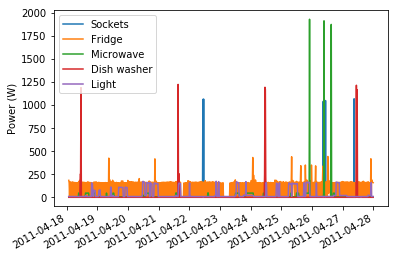

In [18]:
top_5_train_elec.plot()

### Sample rates and downsampling
REDD data set has got appliance level data sampled every 3 or 4 seconds and mains data sampled every 1 second. Let us verify the same.

In [232]:
fridge_meter = train_elec['fridge']
fridge_df = next(fridge_meter.load())
fridge_df.head()

physical_quantity,power
type,active
2011-04-18 01:31:40-04:00,6.0
2011-04-18 01:31:44-04:00,6.0
2011-04-18 01:31:47-04:00,6.0
2011-04-18 01:31:50-04:00,7.0
2011-04-18 01:32:05-04:00,7.0


In [233]:
mains = train_elec.mains()
mains_df = next(mains.load())
mains_df.head()

Loading data for meter ElecMeterID(instance=2, building=2, dataset='REDD')     
Done loading data all meters for this chunk.


physical_quantity,power
type,apparent
2011-04-17 19:18:27-04:00,306.809998
2011-04-17 19:18:28-04:00,306.319977
2011-04-17 19:18:29-04:00,306.400024
2011-04-17 19:18:30-04:00,305.760010
2011-04-17 19:18:31-04:00,321.360016


### Get good sections
If we plot the raw power data then we see there is one large gap where, supposedly, the metering system was not working.

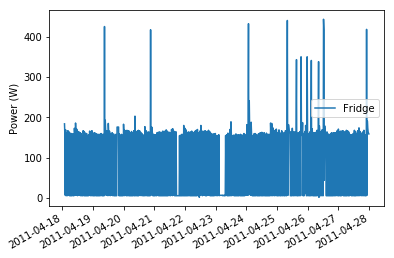

In [234]:
fridge_meter.plot()

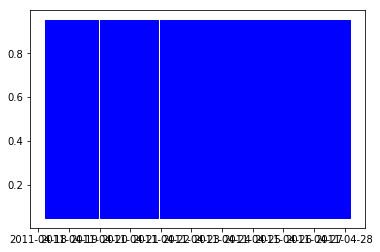

In [235]:
good_sections = fridge_meter.good_sections(full_results=True)
good_sections.plot()

### Dropout rate
This is a number between 0 and 1 which specifies the proportion of missing samples. A value of 0 means no samples are missing while 1, all samples are missing.

In [23]:
# For the mains
test_mains_dropout = test_elec.mains().dropout_rate()
print('\n\nTest mains dropout rate', test_mains_dropout)

# For an appliance, say fridge
test_frige_dropout = fridge_meter.dropout_rate()
print('\nTest fridge dropout rate', test_frige_dropout)

Calculating dropout_rate for ElecMeterID(instance=2, building=2, dataset='REDD') ...   

Test mains dropout rate 0.01978094601686972

Test fridge dropout rate 0.20430368586965642


### Training and disaggregation
We define some helper functions which facilitate training, prediction, and validation in iterations of data over different sample periods as follows:

In [24]:
def find_intersection(gt, pred, timezone):
    """
    We find the index intersection by converting to UTC and then back to the local timezone.
    """
    gt_index_utc = gt.index.tz_convert("UTC")
    pred_index_utc = pred.index.tz_convert("UTC")
    common_index_utc = gt_index_utc.intersection(pred_index_utc)

    local_timezone = train_set.metadata['timezone']
    common_index_local = common_index_utc.tz_convert(timezone)

    gt = gt.ix[common_index_local]
    pred = pred.ix[common_index_local]
    
    return gt, pred

In [25]:
# The following function takes a classifier model, test dataset, sample_period and timezone.
def predict(clf, test_elec, sample_period, timezone):
    """
    Here, we get declare two dictionaries: 
    one to hold the ground truth and the other to hold the predictions
    """
    pred = {}
    gt = {}

    # Get each chunk sampled at sample_period
    for i, chunk in enumerate(test_elec.mains().load(sample_period=sample_period)):
        # Drop N/A in the chunk
        chunk_drop_na = chunk.dropna()
        # Decompose the chunk
        pred[i] = clf.disaggregate_chunk(chunk_drop_na)

        # Extract the ground truth compositions
        gt[i] = {}
        for meter in test_elec.submeters().meters:
            # Only use the meters that we trained on (this saves time!)    
            gt[i][meter] = next(meter.load(sample_period=sample_period))

        gt[i] = pd.DataFrame({k:v.squeeze() for k,v in iteritems(gt[i])}, index=next(iter(gt[i].values())).index)
        gt[i] = gt[i].dropna()
        
    """
    We concatenate all the junks data and select only the columns for the top-k appliance we trained on, 
    and finally format the columns to be in the same order, in both prediction and ground truth.
    """
    gt_overall = pd.concat(gt)
    gt_overall.index = gt_overall.index.droplevel()
    pred_overall = pd.concat(pred)
    pred_overall.index = pred_overall.index.droplevel()

    # Having the same order of columns
    gt_overall = gt_overall[pred_overall.columns]

    # Intersection of index
    gt_overall, pred_overall = find_intersection(gt_overall, pred_overall, timezone);

    # Using prettier names!
    appliance_labels = [m.label() for m in gt_overall.columns.values]
    gt_overall.columns = appliance_labels
    pred_overall.columns = appliance_labels

    return gt_overall, pred_overall

We compute the errors.

In [26]:
def compute_rmse(gt, pred):
    rms_error = {}
    for appliance in gt.columns:
        rms_error[appliance] = np.sqrt(mean_squared_error(gt[appliance], pred[appliance]))
    return pd.Series(rms_error)

In [153]:
def run_disaggregator(classifier, train_elec, test_elec, sample_period, timezone):
    # Training and disaggregation times be used for performance test
    runtime = {}
    start = time.time()
    # Training the model
    classifier.train(train_elec, sample_period=sample_period)
    runtime['training'] = time.time() - start
    
    start = time.time()
    # We then make prediction for the model
    gt, pred = predict(classifier, test_elec, sample_period, timezone)
    runtime['prediction'] = time.time() - start
    
    # Compute the rmse
    rmse = compute_rmse(gt, pred)
    
    return gt, pred, rmse, pd.Series(runtime)

We start by taking a model and a sampling period and run the disaggregator function.

In [154]:
# Desampling to sample_period seconds resolution
sample_period = 60
classifier = fhmm_exact.FHMM()
timezone = train_set.metadata['timezone']

gt, pred, rmse, runtime = run_disaggregator(classifier, top_5_train_elec, test_elec, sample_period, timezone)

Training model for submeter 'ElecMeter(instance=8, building=2, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])'
Training model for submeter 'ElecMeter(instance=9, building=2, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])'
Training model for submeter 'ElecMeter(instance=6, building=2, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])'
Training model for submeter 'ElecMeter(instance=10, building=2, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])'
Training model for submeter 'ElecMeter(instance=4, building=2, dataset='REDD', appliances=[Appliance(type='light', instance=1)])'
Loading data for meter ElecMeterID(instance=2, building=2, dataset='REDD')     
Done loading data all meters for this chunk.


Let us assess the runtime and RMSE performances:

In [155]:
pd.DataFrame(runtime, columns=['FHMM_EXACT runtime'])

,FHMM_EXACT runtime
prediction,6.810888
training,3.238356


In [156]:
fhmm_rmse = pd.DataFrame(rmse, columns=['FHMM_EXACT RMSE'])
fhmm_rmse

,FHMM_EXACT RMSE
Dish washer,140.655961
Fridge,140.195129
Light,127.499494
Microwave,58.879628
Sockets,44.612464


We take a look at a small chunk of test mains reading and then its real and predicted compositions.

In [157]:
chunk = next(test_elec.mains().load(sample_period=sample_period))
# Drop N/A in the chunk
chunk_drop_na = chunk.dropna()
print('\nThe raw single point meter measurements')
print(chunk_drop_na.head())

Loading data for meter ElecMeterID(instance=2, building=2, dataset='REDD')     
Done loading data all meters for this chunk.

The raw single point meter measurements
physical_quantity               power
type                         apparent
2011-04-28 00:00:00-04:00  267.119995
2011-04-28 00:01:00-04:00   37.599998
2011-04-28 00:02:00-04:00   37.599998
2011-04-28 00:03:00-04:00   37.720001
2011-04-28 00:04:00-04:00   37.690002


We have a peep at the ground truth and the data predicted by one of the models.

In [158]:
gt.head()

,Sockets,Fridge,Microwave,Dish washer,Light
2011-04-28 00:00:00-04:00,1.0,155.0,5.0,0.0,9.0
2011-04-28 00:01:00-04:00,1.0,6.0,4.0,0.0,8.0
2011-04-28 00:02:00-04:00,1.0,6.0,4.0,1.0,8.0
2011-04-28 00:03:00-04:00,1.0,6.0,4.0,0.0,8.0
2011-04-28 00:04:00-04:00,1.0,7.0,4.0,0.0,8.0


In [159]:
pred.head()

,Sockets,Fridge,Microwave,Dish washer,Light
2011-04-28 00:00:00-04:00,1.0,204.0,5.0,0.0,24.0
2011-04-28 00:01:00-04:00,1.0,6.0,5.0,0.0,24.0
2011-04-28 00:02:00-04:00,1.0,6.0,5.0,0.0,24.0
2011-04-28 00:03:00-04:00,1.0,6.0,5.0,0.0,24.0
2011-04-28 00:04:00-04:00,1.0,6.0,5.0,0.0,24.0


We visualize the two data.

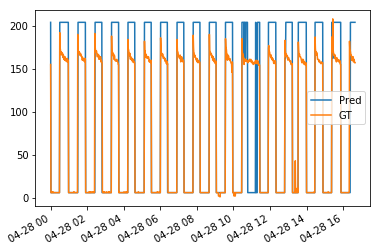

In [246]:
pred['Fridge'].head(1000).plot(label="Pred")
gt['Fridge'].head(1000).plot(label="GT")
ax = plt.legend()

We now train our models using different sample periods, desampling since both our site/main meters and submeters are sampled at different frequencies.

In [203]:
# Desampling to sample_period resolutions (in seconds)
sample_periods = np.arange(10, 121, 10)
timezone = train_set.metadata['timezone']

#### FHMM_EXACT model

In [193]:
fhmm_clf = fhmm_exact.FHMM()
rms_errors = {}
runtime = {}

for sample_period in tqdm(sample_periods):
    print('\n')
    print("*"*20)
    print('Sample period:', sample_period, 'seconds')
    print("*" *20)
    _, _, rms_errors[sample_period], runtime[sample_period] = run_disaggregator(fhmm_clf, top_5_train_elec, test_elec, sample_period, timezone)



  0%|          | 0/12 [00:00<?, ?it/s]



********************
Sample period: 10 seconds
********************
Training model for submeter 'ElecMeter(instance=8, building=2, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])'
Training model for submeter 'ElecMeter(instance=9, building=2, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])'
Training model for submeter 'ElecMeter(instance=6, building=2, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])'
Training model for submeter 'ElecMeter(instance=10, building=2, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])'
Training model for submeter 'ElecMeter(instance=4, building=2, dataset='REDD', appliances=[Appliance(type='light', instance=1)])'
Loading data for meter ElecMeterID(instance=2, building=2, dataset='REDD')     
Done loading data all meters for this chunk.




  8%|▊         | 1/12 [00:45<08:24, 45.85s/it]



********************
Sample period: 20 seconds
********************
Training model for submeter 'ElecMeter(instance=8, building=2, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])'
Training model for submeter 'ElecMeter(instance=9, building=2, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])'
Training model for submeter 'ElecMeter(instance=6, building=2, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])'
Training model for submeter 'ElecMeter(instance=10, building=2, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])'
Training model for submeter 'ElecMeter(instance=4, building=2, dataset='REDD', appliances=[Appliance(type='light', instance=1)])'
Loading data for meter ElecMeterID(instance=2, building=2, dataset='REDD')     
Done loading data all meters for this chunk.




 17%|█▋        | 2/12 [01:09<06:32, 39.28s/it]



********************
Sample period: 30 seconds
********************
Training model for submeter 'ElecMeter(instance=8, building=2, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])'
Training model for submeter 'ElecMeter(instance=9, building=2, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])'
Training model for submeter 'ElecMeter(instance=6, building=2, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])'
Training model for submeter 'ElecMeter(instance=10, building=2, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])'
Training model for submeter 'ElecMeter(instance=4, building=2, dataset='REDD', appliances=[Appliance(type='light', instance=1)])'
Loading data for meter ElecMeterID(instance=2, building=2, dataset='REDD')     
Done loading data all meters for this chunk.




 25%|██▌       | 3/12 [01:26<04:53, 32.59s/it]



********************
Sample period: 40 seconds
********************
Training model for submeter 'ElecMeter(instance=8, building=2, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])'
Training model for submeter 'ElecMeter(instance=9, building=2, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])'
Training model for submeter 'ElecMeter(instance=6, building=2, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])'
Training model for submeter 'ElecMeter(instance=10, building=2, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])'
Training model for submeter 'ElecMeter(instance=4, building=2, dataset='REDD', appliances=[Appliance(type='light', instance=1)])'
Loading data for meter ElecMeterID(instance=2, building=2, dataset='REDD')     
Done loading data all meters for this chunk.




 33%|███▎      | 4/12 [01:39<03:33, 26.71s/it]



********************
Sample period: 50 seconds
********************
Training model for submeter 'ElecMeter(instance=8, building=2, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])'
Training model for submeter 'ElecMeter(instance=9, building=2, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])'
Training model for submeter 'ElecMeter(instance=6, building=2, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])'
Training model for submeter 'ElecMeter(instance=10, building=2, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])'
Training model for submeter 'ElecMeter(instance=4, building=2, dataset='REDD', appliances=[Appliance(type='light', instance=1)])'
Loading data for meter ElecMeterID(instance=2, building=2, dataset='REDD')     
Done loading data all meters for this chunk.




 42%|████▏     | 5/12 [01:51<02:35, 22.14s/it]



********************
Sample period: 60 seconds
********************
Training model for submeter 'ElecMeter(instance=8, building=2, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])'
Training model for submeter 'ElecMeter(instance=9, building=2, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])'
Training model for submeter 'ElecMeter(instance=6, building=2, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])'
Training model for submeter 'ElecMeter(instance=10, building=2, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])'
Training model for submeter 'ElecMeter(instance=4, building=2, dataset='REDD', appliances=[Appliance(type='light', instance=1)])'
Loading data for meter ElecMeterID(instance=2, building=2, dataset='REDD')     
Done loading data all meters for this chunk.




 50%|█████     | 6/12 [02:00<01:50, 18.38s/it]



********************
Sample period: 70 seconds
********************
Training model for submeter 'ElecMeter(instance=8, building=2, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])'
Training model for submeter 'ElecMeter(instance=9, building=2, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])'
Training model for submeter 'ElecMeter(instance=6, building=2, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])'
Training model for submeter 'ElecMeter(instance=10, building=2, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])'
Training model for submeter 'ElecMeter(instance=4, building=2, dataset='REDD', appliances=[Appliance(type='light', instance=1)])'
Loading data for meter ElecMeterID(instance=2, building=2, dataset='REDD')     
Done loading data all meters for this chunk.




 58%|█████▊    | 7/12 [02:09<01:17, 15.45s/it]



********************
Sample period: 80 seconds
********************
Training model for submeter 'ElecMeter(instance=8, building=2, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])'
Training model for submeter 'ElecMeter(instance=9, building=2, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])'
Training model for submeter 'ElecMeter(instance=6, building=2, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])'
Training model for submeter 'ElecMeter(instance=10, building=2, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])'
Training model for submeter 'ElecMeter(instance=4, building=2, dataset='REDD', appliances=[Appliance(type='light', instance=1)])'
Loading data for meter ElecMeterID(instance=2, building=2, dataset='REDD')     
Done loading data all meters for this chunk.




 67%|██████▋   | 8/12 [02:17<00:52, 13.19s/it]



********************
Sample period: 90 seconds
********************
Training model for submeter 'ElecMeter(instance=8, building=2, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])'
Training model for submeter 'ElecMeter(instance=9, building=2, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])'
Training model for submeter 'ElecMeter(instance=6, building=2, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])'
Training model for submeter 'ElecMeter(instance=10, building=2, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])'
Training model for submeter 'ElecMeter(instance=4, building=2, dataset='REDD', appliances=[Appliance(type='light', instance=1)])'
Loading data for meter ElecMeterID(instance=2, building=2, dataset='REDD')     
Done loading data all meters for this chunk.




 75%|███████▌  | 9/12 [02:24<00:34, 11.43s/it]



********************
Sample period: 100 seconds
********************
Training model for submeter 'ElecMeter(instance=8, building=2, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])'
Training model for submeter 'ElecMeter(instance=9, building=2, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])'
Training model for submeter 'ElecMeter(instance=6, building=2, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])'
Training model for submeter 'ElecMeter(instance=10, building=2, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])'
Training model for submeter 'ElecMeter(instance=4, building=2, dataset='REDD', appliances=[Appliance(type='light', instance=1)])'
Loading data for meter ElecMeterID(instance=2, building=2, dataset='REDD')     
Done loading data all meters for this chunk.




 83%|████████▎ | 10/12 [02:31<00:20, 10.13s/it]



********************
Sample period: 110 seconds
********************
Training model for submeter 'ElecMeter(instance=8, building=2, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])'
Training model for submeter 'ElecMeter(instance=9, building=2, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])'
Training model for submeter 'ElecMeter(instance=6, building=2, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])'
Training model for submeter 'ElecMeter(instance=10, building=2, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])'
Training model for submeter 'ElecMeter(instance=4, building=2, dataset='REDD', appliances=[Appliance(type='light', instance=1)])'
Loading data for meter ElecMeterID(instance=2, building=2, dataset='REDD')     
Done loading data all meters for this chunk.




 92%|█████████▏| 11/12 [02:38<00:09,  9.16s/it]



********************
Sample period: 120 seconds
********************
Training model for submeter 'ElecMeter(instance=8, building=2, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])'
Training model for submeter 'ElecMeter(instance=9, building=2, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])'
Training model for submeter 'ElecMeter(instance=6, building=2, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])'
Training model for submeter 'ElecMeter(instance=10, building=2, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])'
Training model for submeter 'ElecMeter(instance=4, building=2, dataset='REDD', appliances=[Appliance(type='light', instance=1)])'
Loading data for meter ElecMeterID(instance=2, building=2, dataset='REDD')     
Done loading data all meters for this chunk.




100%|██████████| 12/12 [02:44<00:00,  8.28s/it]



In [194]:
fhmm_errors = pd.DataFrame(rms_errors)
fhmm_errors

,10,20,30,40,50,60,70,80,90,100,110,120
Dish washer,139.000068,137.768633,138.922977,140.283861,138.686955,140.655961,140.067014,140.733808,35.814256,43.717392,139.115273,32.766081
Fridge,140.329618,140.504319,140.678843,139.804039,139.772217,140.195129,140.501240,140.136208,48.807559,52.191678,139.787796,47.928737
Light,128.140983,128.112742,128.089554,127.441318,127.532986,127.499494,128.057745,128.018991,33.213382,23.826970,127.624433,33.894106
Microwave,53.836162,52.964010,57.290957,56.378152,62.641545,58.879628,43.078601,39.787859,58.285617,58.091717,12.499118,38.622938
Sockets,42.858296,46.001410,42.990253,43.693233,50.703240,44.612464,51.211450,62.793751,65.620935,59.898007,57.530294,55.851661


Text(0.5,0,'Sample Period in Seconds')

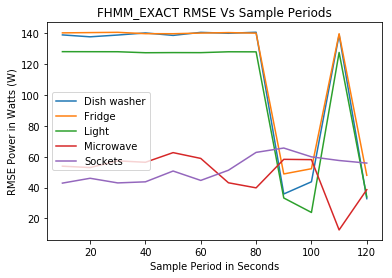

In [241]:
ax = fhmm_errors.T.plot(title='FHMM_EXACT RMSE Vs Sample Periods')
ax.set_ylabel("RMSE Power in Watts (W)")
ax.set_xlabel("Sample Period in Seconds")

In [198]:
fhmm_runtime = pd.DataFrame(runtime)
fhmm_runtime

,10,20,30,40,50,60,70,80,90,100,110,120
prediction,30.917107,16.269817,11.518802,8.997481,7.662440,6.559492,5.829974,5.312861,4.903709,4.594757,4.341364,4.109041
training,14.900791,7.626413,5.447155,3.987875,3.811524,3.015861,2.785202,2.585034,2.417538,2.480298,2.538810,2.115225


Text(0.5,0,'Sample Period in Seconds')

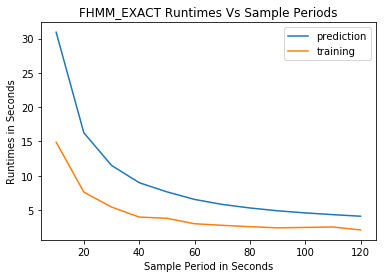

In [240]:
ax = fhmm_runtime.T.plot(title='FHMM_EXACT Runtimes Vs Sample Periods')
ax.set_ylabel("Runtimes in Seconds")
ax.set_xlabel("Sample Period in Seconds")

#### CO model

classifiers = {'CO':CombinatorialOptimisation(), 'FHMM_EXACT':fhmm_exact.FHMM()}

In [237]:
rms_errors = {}
runtime = {}

for sample_period in tqdm(sample_periods):
    print('\n')
    print("*"*20)
    print('Sample period:', sample_period, 'seconds')
    print("*" *20)
    co_clf = CombinatorialOptimisation()
    _, _, rms_errors[sample_period], runtime[sample_period] = run_disaggregator(co_clf, top_5_train_elec, test_elec, sample_period, timezone)



  0%|          | 0/12 [00:00<?, ?it/s]



********************
Sample period: 10 seconds
********************
Training model for submeter 'ElecMeter(instance=8, building=2, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])'
Training model for submeter 'ElecMeter(instance=9, building=2, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])'
Training model for submeter 'ElecMeter(instance=6, building=2, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])'
Training model for submeter 'ElecMeter(instance=10, building=2, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])'
Training model for submeter 'ElecMeter(instance=4, building=2, dataset='REDD', appliances=[Appliance(type='light', instance=1)])'
Done training!
Loading data for meter ElecMeterID(instance=2, building=2, dataset='REDD')     
Done loading data all meters for this chunk.
Estimating power demand for 'ElecMeter(instance=8, building=2, dataset='REDD', appliances=[Appliance(type='sockets', instance=



  8%|▊         | 1/12 [00:03<00:43,  3.99s/it]



********************
Sample period: 20 seconds
********************
Training model for submeter 'ElecMeter(instance=8, building=2, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])'
Training model for submeter 'ElecMeter(instance=9, building=2, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])'
Training model for submeter 'ElecMeter(instance=6, building=2, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])'
Training model for submeter 'ElecMeter(instance=10, building=2, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])'
Training model for submeter 'ElecMeter(instance=4, building=2, dataset='REDD', appliances=[Appliance(type='light', instance=1)])'
Done training!
Loading data for meter ElecMeterID(instance=2, building=2, dataset='REDD')     
Done loading data all meters for this chunk.
Estimating power demand for 'ElecMeter(instance=8, building=2, dataset='REDD', appliances=[Appliance(type='sockets', instance=



 17%|█▋        | 2/12 [00:07<00:38,  3.83s/it]



********************
Sample period: 30 seconds
********************
Training model for submeter 'ElecMeter(instance=8, building=2, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])'
Training model for submeter 'ElecMeter(instance=9, building=2, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])'
Training model for submeter 'ElecMeter(instance=6, building=2, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])'
Training model for submeter 'ElecMeter(instance=10, building=2, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])'
Training model for submeter 'ElecMeter(instance=4, building=2, dataset='REDD', appliances=[Appliance(type='light', instance=1)])'
Done training!
Loading data for meter ElecMeterID(instance=2, building=2, dataset='REDD')     
Done loading data all meters for this chunk.
Estimating power demand for 'ElecMeter(instance=8, building=2, dataset='REDD', appliances=[Appliance(type='sockets', instance=



 25%|██▌       | 3/12 [00:10<00:33,  3.72s/it]



********************
Sample period: 40 seconds
********************
Training model for submeter 'ElecMeter(instance=8, building=2, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])'
Training model for submeter 'ElecMeter(instance=9, building=2, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])'
Training model for submeter 'ElecMeter(instance=6, building=2, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])'
Training model for submeter 'ElecMeter(instance=10, building=2, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])'
Training model for submeter 'ElecMeter(instance=4, building=2, dataset='REDD', appliances=[Appliance(type='light', instance=1)])'
Done training!
Loading data for meter ElecMeterID(instance=2, building=2, dataset='REDD')     
Done loading data all meters for this chunk.
Estimating power demand for 'ElecMeter(instance=8, building=2, dataset='REDD', appliances=[Appliance(type='sockets', instance=



 33%|███▎      | 4/12 [00:14<00:28,  3.60s/it]



********************
Sample period: 50 seconds
********************
Training model for submeter 'ElecMeter(instance=8, building=2, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])'
Training model for submeter 'ElecMeter(instance=9, building=2, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])'
Training model for submeter 'ElecMeter(instance=6, building=2, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])'
Training model for submeter 'ElecMeter(instance=10, building=2, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])'
Training model for submeter 'ElecMeter(instance=4, building=2, dataset='REDD', appliances=[Appliance(type='light', instance=1)])'
Done training!
Loading data for meter ElecMeterID(instance=2, building=2, dataset='REDD')     
Done loading data all meters for this chunk.
Estimating power demand for 'ElecMeter(instance=8, building=2, dataset='REDD', appliances=[Appliance(type='sockets', instance=



 42%|████▏     | 5/12 [00:17<00:24,  3.47s/it]



********************
Sample period: 60 seconds
********************
Training model for submeter 'ElecMeter(instance=8, building=2, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])'
Training model for submeter 'ElecMeter(instance=9, building=2, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])'
Training model for submeter 'ElecMeter(instance=6, building=2, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])'
Training model for submeter 'ElecMeter(instance=10, building=2, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])'
Training model for submeter 'ElecMeter(instance=4, building=2, dataset='REDD', appliances=[Appliance(type='light', instance=1)])'
Done training!
Loading data for meter ElecMeterID(instance=2, building=2, dataset='REDD')     
Done loading data all meters for this chunk.
Estimating power demand for 'ElecMeter(instance=8, building=2, dataset='REDD', appliances=[Appliance(type='sockets', instance=



 50%|█████     | 6/12 [00:20<00:20,  3.43s/it]



********************
Sample period: 70 seconds
********************
Training model for submeter 'ElecMeter(instance=8, building=2, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])'
Training model for submeter 'ElecMeter(instance=9, building=2, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])'
Training model for submeter 'ElecMeter(instance=6, building=2, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])'
Training model for submeter 'ElecMeter(instance=10, building=2, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])'
Training model for submeter 'ElecMeter(instance=4, building=2, dataset='REDD', appliances=[Appliance(type='light', instance=1)])'
Done training!
Loading data for meter ElecMeterID(instance=2, building=2, dataset='REDD')     
Done loading data all meters for this chunk.
Estimating power demand for 'ElecMeter(instance=8, building=2, dataset='REDD', appliances=[Appliance(type='sockets', instance=



 58%|█████▊    | 7/12 [00:23<00:16,  3.34s/it]



********************
Sample period: 80 seconds
********************
Training model for submeter 'ElecMeter(instance=8, building=2, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])'
Training model for submeter 'ElecMeter(instance=9, building=2, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])'
Training model for submeter 'ElecMeter(instance=6, building=2, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])'
Training model for submeter 'ElecMeter(instance=10, building=2, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])'
Training model for submeter 'ElecMeter(instance=4, building=2, dataset='REDD', appliances=[Appliance(type='light', instance=1)])'
Done training!
Loading data for meter ElecMeterID(instance=2, building=2, dataset='REDD')     
Done loading data all meters for this chunk.
Estimating power demand for 'ElecMeter(instance=8, building=2, dataset='REDD', appliances=[Appliance(type='sockets', instance=



 67%|██████▋   | 8/12 [00:27<00:13,  3.37s/it]



********************
Sample period: 90 seconds
********************
Training model for submeter 'ElecMeter(instance=8, building=2, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])'
Training model for submeter 'ElecMeter(instance=9, building=2, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])'
Training model for submeter 'ElecMeter(instance=6, building=2, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])'
Training model for submeter 'ElecMeter(instance=10, building=2, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])'
Training model for submeter 'ElecMeter(instance=4, building=2, dataset='REDD', appliances=[Appliance(type='light', instance=1)])'
Done training!
Loading data for meter ElecMeterID(instance=2, building=2, dataset='REDD')     
Done loading data all meters for this chunk.
Estimating power demand for 'ElecMeter(instance=8, building=2, dataset='REDD', appliances=[Appliance(type='sockets', instance=



 75%|███████▌  | 9/12 [00:30<00:09,  3.28s/it]



********************
Sample period: 100 seconds
********************
Training model for submeter 'ElecMeter(instance=8, building=2, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])'
Training model for submeter 'ElecMeter(instance=9, building=2, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])'
Training model for submeter 'ElecMeter(instance=6, building=2, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])'
Training model for submeter 'ElecMeter(instance=10, building=2, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])'
Training model for submeter 'ElecMeter(instance=4, building=2, dataset='REDD', appliances=[Appliance(type='light', instance=1)])'
Done training!
Loading data for meter ElecMeterID(instance=2, building=2, dataset='REDD')     
Done loading data all meters for this chunk.
Estimating power demand for 'ElecMeter(instance=8, building=2, dataset='REDD', appliances=[Appliance(type='sockets', instance



 83%|████████▎ | 10/12 [00:33<00:06,  3.27s/it]



********************
Sample period: 110 seconds
********************
Training model for submeter 'ElecMeter(instance=8, building=2, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])'
Training model for submeter 'ElecMeter(instance=9, building=2, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])'
Training model for submeter 'ElecMeter(instance=6, building=2, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])'
Training model for submeter 'ElecMeter(instance=10, building=2, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])'
Training model for submeter 'ElecMeter(instance=4, building=2, dataset='REDD', appliances=[Appliance(type='light', instance=1)])'
Done training!
Loading data for meter ElecMeterID(instance=2, building=2, dataset='REDD')     
Done loading data all meters for this chunk.
Estimating power demand for 'ElecMeter(instance=8, building=2, dataset='REDD', appliances=[Appliance(type='sockets', instance



 92%|█████████▏| 11/12 [00:37<00:03,  3.33s/it]



********************
Sample period: 120 seconds
********************
Training model for submeter 'ElecMeter(instance=8, building=2, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])'
Training model for submeter 'ElecMeter(instance=9, building=2, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])'
Training model for submeter 'ElecMeter(instance=6, building=2, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])'
Training model for submeter 'ElecMeter(instance=10, building=2, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])'
Training model for submeter 'ElecMeter(instance=4, building=2, dataset='REDD', appliances=[Appliance(type='light', instance=1)])'
Done training!
Loading data for meter ElecMeterID(instance=2, building=2, dataset='REDD')     
Done loading data all meters for this chunk.
Estimating power demand for 'ElecMeter(instance=8, building=2, dataset='REDD', appliances=[Appliance(type='sockets', instance



100%|██████████| 12/12 [00:40<00:00,  3.25s/it]



In [206]:
co_errors = pd.DataFrame(rms_errors)
co_errors

,10,20,30,40,50,60,70,80,90,100,110,120
Dish washer,53.872993,198.096344,207.628937,201.213913,204.343536,209.032043,202.830536,203.914719,202.733994,210.766388,216.656967,203.903976
Fridge,39.527504,151.592087,150.982224,149.088226,150.624084,151.182098,150.430618,150.591354,151.590195,150.534698,150.792389,150.884583
Light,23.344666,24.957773,24.040712,22.371605,23.918926,24.317369,24.322390,24.153568,23.989111,23.311731,23.759499,24.581930
Microwave,30.738100,50.423512,47.045082,29.369650,56.060436,48.120991,59.287300,45.591412,46.524567,57.129211,46.485432,49.734592
Sockets,105.005966,68.886757,40.985840,62.614017,49.514221,43.604481,51.569683,40.829903,44.555859,53.264484,42.137463,42.537582


Text(0.5,0,'Sample Period in Seconds')

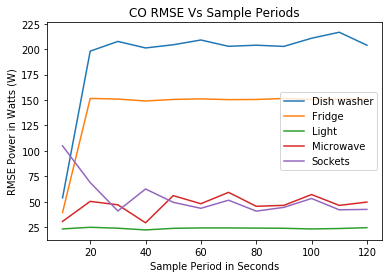

In [242]:
ax = co_errors.T.plot(title='CO RMSE Vs Sample Periods')
ax.set_ylabel("RMSE Power in Watts (W)")
ax.set_xlabel("Sample Period in Seconds")

In [208]:
co_runtime = pd.DataFrame(runtime)
co_runtime

,10,20,30,40,50,60,70,80,90,100,110,120
prediction,1.922445,2.088187,2.089385,1.999557,2.301869,2.046305,1.944635,1.941797,1.975369,1.996101,2.022040,1.890914
training,1.347707,1.287058,1.517281,1.239338,1.401193,1.495954,1.302799,1.361647,1.383784,1.111477,1.323692,1.243906


Text(0.5,0,'Sample Period in Seconds')

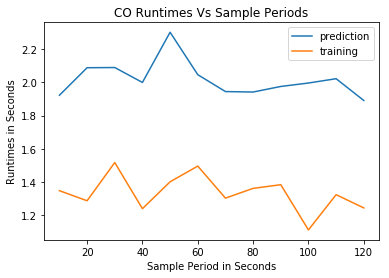

In [243]:
ax = co_runtime.T.plot(title='CO Runtimes Vs Sample Periods')
ax.set_ylabel("Runtimes in Seconds")
ax.set_xlabel("Sample Period in Seconds")